In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from datetime import datetime
import json

In [2]:
# Neural Networks for Actor and Critic
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Actor network: state -> action probabilities
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        
        # Critic network: state -> value
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        
    def act(self, state):
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action), dist.entropy()
    
    def evaluate(self, state, action):
        probs = self.actor(state)
        dist = Categorical(probs)
        action_logprob = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprob, state_value, dist_entropy

# Memory Buffer for storing experiences
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.values = []
    
    def clear(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.values = []

In [3]:
class PPO:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.98, K_epochs=20):
        self.policy = ActorCritic(state_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.memory = Memory()
        
        # Hyperparameters
        self.gamma = gamma         # discount factor
        self.eps_clip = 0.2        # clip parameter for PPO
        self.K_epochs = K_epochs   # update policy for K epochs
        self.entropy_coef = 0.01   # entropy coefficient
        self.value_coef = 0.5      # value loss coefficient
        
    def select_action(self, state):
        with torch.no_grad():
            state = torch.FloatTensor(state)
            action, action_logprob, entropy = self.policy.act(state)
            value = self.policy.critic(state)
        
        # Store experience in memory
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(action_logprob)
        self.memory.values.append(value.squeeze())
        
        return action.item()
    
    def compute_returns(self, next_value):
        # Compute returns using GAE
        gae = 0
        returns = []
        values = self.memory.values + [next_value]
        for step in reversed(range(len(self.memory.rewards))):
            delta = (self.memory.rewards[step] + 
                    self.gamma * values[step + 1] * (1 - self.memory.is_terminals[step]) - 
                    values[step])
            gae = delta + self.gamma * 0.95 * (1 - self.memory.is_terminals[step]) * gae
            returns.insert(0, gae + values[step])
        return returns
    
    def update(self, next_value):
        returns = self.compute_returns(next_value)
        returns = torch.tensor(returns)
        
        # Get experiences from memory
        old_states = torch.stack(self.memory.states)
        old_actions = torch.stack(self.memory.actions)
        old_logprobs = torch.stack(self.memory.logprobs)
        old_values = torch.stack(self.memory.values)
        
        # Compute advantages
        advantages = returns - old_values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
        
        # PPO update for K epochs
        for _ in range(self.K_epochs):
            # Get current policy outputs
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = state_values.squeeze()
            
            # Compute PPO loss
            ratios = torch.exp(logprobs - old_logprobs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = self.value_coef * ((state_values - returns.detach())**2).mean()
            entropy_loss = -self.entropy_coef * dist_entropy.mean()
            
            # Update policy
            total_loss = policy_loss + value_loss + entropy_loss
            self.optimizer.zero_grad()
            total_loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
        
        self.memory.clear()


Starting PPO training on CartPole-v1...
Episode   0 | Reward:  21.0 | Running Reward:   1.1
Episode  10 | Reward:  23.0 | Running Reward:  12.8
Episode  20 | Reward:  15.0 | Running Reward:  24.4
Episode  30 | Reward:  24.0 | Running Reward:  26.5
Episode  40 | Reward:  29.0 | Running Reward:  28.0
Episode  50 | Reward: 103.0 | Running Reward:  49.0
Episode  60 | Reward:  77.0 | Running Reward:  61.6
Episode  70 | Reward: 292.0 | Running Reward: 110.5
Episode  80 | Reward: 222.0 | Running Reward: 137.1
Episode  90 | Reward: 385.0 | Running Reward: 174.3
Episode 100 | Reward:  32.0 | Running Reward: 181.7
Episode 110 | Reward:  22.0 | Running Reward: 144.0
Episode 120 | Reward:  77.0 | Running Reward: 110.2
Episode 130 | Reward: 125.0 | Running Reward: 127.2
Episode 140 | Reward: 257.0 | Running Reward: 179.6
Episode 150 | Reward: 500.0 | Running Reward: 281.1
Episode 160 | Reward:  86.0 | Running Reward: 296.8
Episode 170 | Reward: 500.0 | Running Reward: 325.6
Episode 180 | Reward: 3

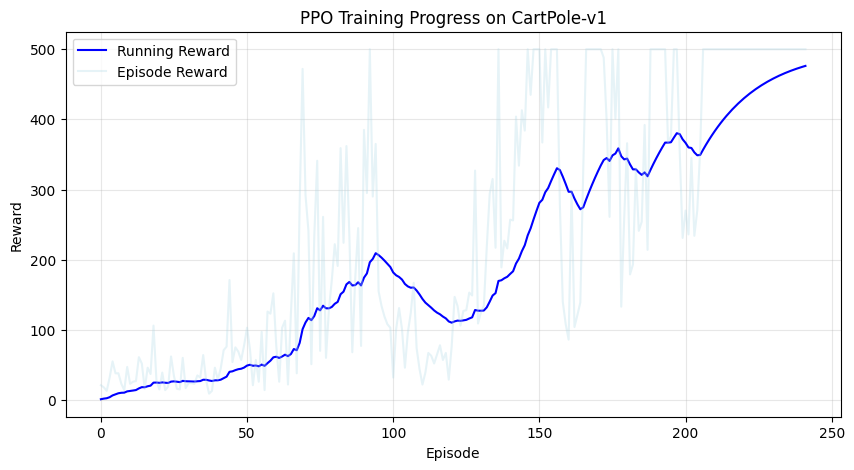

In [4]:
def train_ppo():
    # Training hyperparameters
    max_episodes = 1000
    max_timesteps = 500
    update_timestep = 128
    log_interval = 10
    
    # Initialize environment and agent
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    ppo = PPO(state_dim, action_dim)
    
    # Logging setup
    log_data = {
        'episodes': [],
        'rewards': [],
        'avg_rewards': []
    }
    running_reward = 0
    timestep = 0
    
    print("\nStarting PPO training on CartPole-v1...")
    print("=========================================")
    
    # Training loop
    for i in range(max_episodes):
        state = env.reset()[0]
        episode_reward = 0
        
        for t in range(max_timesteps):
            timestep += 1
            
            # Select and perform action
            action = ppo.select_action(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store experience
            ppo.memory.rewards.append(reward)
            ppo.memory.is_terminals.append(done)
            episode_reward += reward
            
            # Update PPO policy
            if timestep % update_timestep == 0:
                with torch.no_grad():
                    next_value = ppo.policy.critic(torch.FloatTensor(state)).squeeze()
                ppo.update(next_value)
                timestep = 0
            
            if done:
                break
        
        # Update and log results
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward
        
        log_data['episodes'].append(i)
        log_data['rewards'].append(episode_reward)
        log_data['avg_rewards'].append(running_reward)
        
        if i % log_interval == 0:
            print(f'Episode {i:3d} | Reward: {episode_reward:5.1f} | Running Reward: {running_reward:5.1f}')
        
        # Check if solved
        if running_reward > 475:
            print(f"\nSolved! Running reward is {running_reward:.2f}")
            break
    
    env.close()
    
    results_file = f'ppo_results.json'
    with open(results_file, 'w') as f:
        json.dump(log_data, f)
    
    plt.figure(figsize=(10, 5))
    plt.plot(log_data['episodes'], log_data['avg_rewards'], label='Running Reward', color='blue')
    plt.plot(log_data['episodes'], log_data['rewards'], alpha=0.3, label='Episode Reward', color='lightblue')
    plt.title('PPO Training Progress on CartPole-v1')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig(f'ppo_training_plot.png', bbox_inches='tight', dpi=300)
    
    plt.show()
    plt.close()

train_ppo()


Training DQN for 100000 timesteps...

Training A2C for 500000 timesteps...


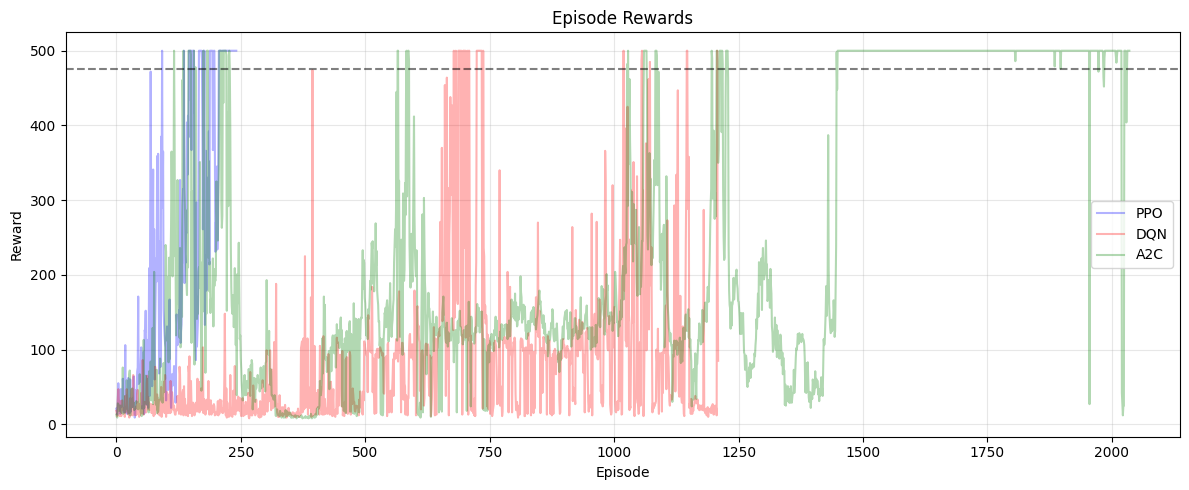

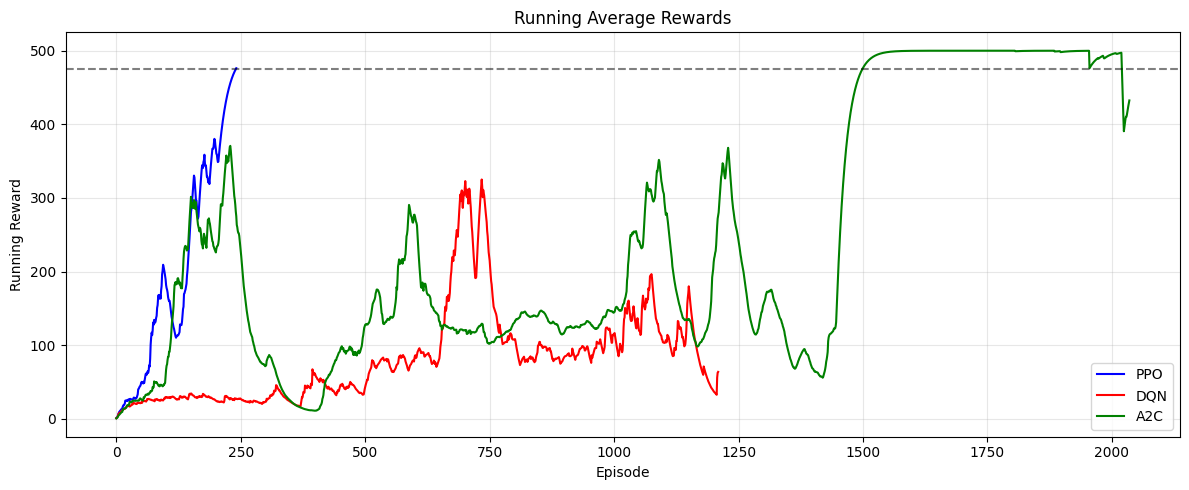

In [5]:
import gymnasium as gym
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.monitor import Monitor

class RewardTrackingEnv(Monitor):
    def __init__(self, env):
        super().__init__(env)
        self.episode_rewards = []
        self.running_rewards = []
        self.running_reward = 0
    
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        if terminated or truncated:
            self.episode_rewards.append(info['episode']['r'])
            self.running_reward = 0.05 * info['episode']['r'] + 0.95 * self.running_reward
            self.running_rewards.append(self.running_reward)
        return obs, reward, terminated, truncated, info

def train_agent(algo_class, env_wrapper, algo_params, total_timesteps, algo_name):
    print(f"\nTraining {algo_name} for {total_timesteps} timesteps...")
    
    env = env_wrapper(gym.make('CartPole-v1'))
    model = algo_class('MlpPolicy', env, verbose=0, **algo_params)
    model.learn(total_timesteps=total_timesteps)
    
    rewards = env.episode_rewards
    running_rewards = env.running_rewards
    
    env.close()
    return rewards, running_rewards

# Hyperparameters from stable-baselines3
dqn_params = {
    'learning_rate': 2.3e-3,
    'batch_size': 64,
    'buffer_size': 100000,
    'learning_starts': 1000,
    'gamma': 0.99,
    'target_update_interval': 10,
    'train_freq': 256,
    'gradient_steps': 128,
    'exploration_fraction': 0.16,
    'exploration_final_eps': 0.04,
    'policy_kwargs': dict(net_arch=[256, 256])
}

a2c_params = {
    'ent_coef': 0.0,
    'policy_kwargs': dict(net_arch=[64, 64])
}

# Train algorithms
dqn_rewards = train_agent(DQN, RewardTrackingEnv, dqn_params, int(1e5), "DQN")
a2c_rewards = train_agent(A2C, RewardTrackingEnv, a2c_params, int(5e5), "A2C")

with open('ppo_results.json', 'r') as f:
    ppo_data = json.load(f)

# Plot 1: Episode Rewards
plt.figure(figsize=(12, 5))
plt.plot(ppo_data['rewards'], label='PPO', color='blue', alpha=0.3)
plt.plot(dqn_rewards[0], label='DQN', color='red', alpha=0.3)
plt.plot(a2c_rewards[0], label='A2C', color='green', alpha=0.3)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=475, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('episode_rewards_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Running Average Rewards
plt.figure(figsize=(12, 5))
plt.plot(ppo_data['avg_rewards'], label='PPO', color='blue')
plt.plot(dqn_rewards[1], label='DQN', color='red')
plt.plot(a2c_rewards[1], label='A2C', color='green')
plt.title('Running Average Rewards')
plt.xlabel('Episode')
plt.ylabel('Running Reward')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=475, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('running_average_rewards_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Sample Efficiency (episodes to threshold):
PPO: 241, DQN: -1, A2C: 1499

Reward Convergence (average ± std over last 100 episodes):
PPO: 415.06 ± 123.41
DQN: 82.00 ± 118.02
A2C: 468.60 ± 112.40


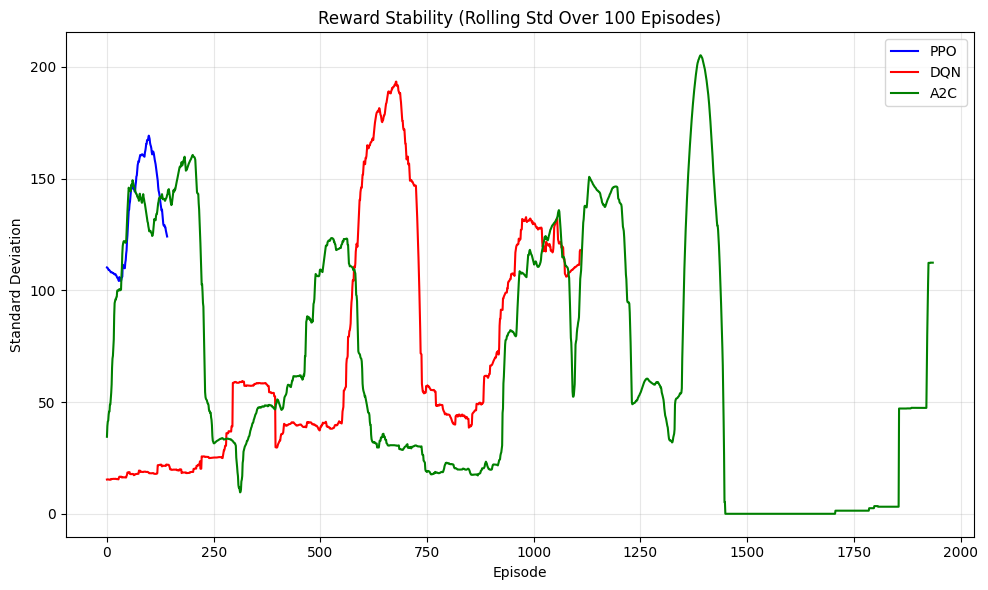

In [6]:
import numpy as np
import matplotlib.pyplot as plt

with open('ppo_results.json', 'r') as f:
    ppo_data = json.load(f)

ppo_rewards = np.array(ppo_data['rewards'])
ppo_running_rewards = np.array(ppo_data['avg_rewards'])
dqn_rewards, dqn_running_rewards = map(np.array, dqn_rewards)
a2c_rewards, a2c_running_rewards = map(np.array, a2c_rewards)

# Define threshold for convergence
reward_threshold = 475

# Calculate Sample Efficiency
def calculate_sample_efficiency(running_rewards, threshold):
    for i, reward in enumerate(running_rewards):
        if reward >= threshold:
            return i
    return -1  # Did not reach the threshold

ppo_sample_efficiency = calculate_sample_efficiency(ppo_running_rewards, reward_threshold)
dqn_sample_efficiency = calculate_sample_efficiency(dqn_running_rewards, reward_threshold)
a2c_sample_efficiency = calculate_sample_efficiency(a2c_running_rewards, reward_threshold)

# Calculate Reward Convergence (Last 100 episodes average)
def calculate_reward_convergence(rewards, last_n=100):
    return np.mean(rewards[-last_n:]), np.std(rewards[-last_n:])

ppo_reward_convergence, ppo_stability = calculate_reward_convergence(ppo_rewards)
dqn_reward_convergence, dqn_stability = calculate_reward_convergence(dqn_rewards)
a2c_reward_convergence, a2c_stability = calculate_reward_convergence(a2c_rewards)

print("Sample Efficiency (episodes to threshold):")
print(f"PPO: {ppo_sample_efficiency}, DQN: {dqn_sample_efficiency}, A2C: {a2c_sample_efficiency}")
print("\nReward Convergence (average ± std over last 100 episodes):")
print(f"PPO: {ppo_reward_convergence:.2f} ± {ppo_stability:.2f}")
print(f"DQN: {dqn_reward_convergence:.2f} ± {dqn_stability:.2f}")
print(f"A2C: {a2c_reward_convergence:.2f} ± {a2c_stability:.2f}")

# Visualize Reward Stability (Std over rolling windows of 100 episodes)
def plot_reward_stability(ppo_rewards, dqn_rewards, a2c_rewards, window=100):
    ppo_std = [np.std(ppo_rewards[i:i+window]) for i in range(len(ppo_rewards)-window)]
    dqn_std = [np.std(dqn_rewards[i:i+window]) for i in range(len(dqn_rewards)-window)]
    a2c_std = [np.std(a2c_rewards[i:i+window]) for i in range(len(a2c_rewards)-window)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(ppo_std, label="PPO", color="blue")
    plt.plot(dqn_std, label="DQN", color="red")
    plt.plot(a2c_std, label="A2C", color="green")
    plt.title("Reward Stability (Rolling Std Over 100 Episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Standard Deviation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("reward_stability.png", dpi=300)
    plt.show()

plot_reward_stability(ppo_rewards, dqn_rewards, a2c_rewards)
